# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1Uo5oCIDzT9rMuHgoQpHJRXj3LdvrwC31
From (redirected): https://drive.google.com/uc?id=1Uo5oCIDzT9rMuHgoQpHJRXj3LdvrwC31&confirm=t&uuid=b290c1d2-b0e6-423b-9f43-2b05c6b39033
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:04<00:00, 104MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zGyloLxtStMuVjJskgMdxkPcIliuSxJ6
From (redirected): https://drive.google.com/uc?id=1zGyloLxtStMuVjJskgMdxkPcIliuSxJ6&confirm=t&uuid=70e43cc9-2baf-4b72-9c7e-1bb062597d7d
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:01<00:00, 86.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NnlrV5iC1le35Rd9mviM9qud5jdBlA6b
From (redirected): https://drive.google.com/uc?id=1NnlrV5iC1le35Rd9mviM9qud5jdBlA6b&confirm=t&uuid=1cd959af-9f04-4254-9aba-84abce4619a5
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:00<00:00, 103MB/s]


## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [2]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

def semantic_to_onehot(semantic_label, num_classes=15):
    """
    Converting semantic label map (H, W) with class indices to one-hot tensor (C, H, W)
    """
    if isinstance(semantic_label, np.ndarray):
        semantic_label = torch.from_numpy(semantic_label).long()
    one_hot = torch.nn.functional.one_hot(semantic_label, num_classes=num_classes)  # (H, W, C)
    one_hot = one_hot.permute(2, 0, 1).float()  # (C, H, W)
    return one_hot


class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Camera (without normalization)
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0

        # History (without normalization)
        history_np = data['sdc_history_feature'].copy()
        # Normalizing heading to [-pi, pi]
        history_np[:, 2] = ((history_np[:, 2] + np.pi) % (2 * np.pi)) - np.pi

        history = torch.FloatTensor(history_np)

        # Depth (without normalization)
        depth = torch.FloatTensor(data['depth'])

        # Semantic to one-hot
        semantic = semantic_to_onehot(data['semantic_label'], num_classes=15)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic
            }


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DrivingPlanner(nn.Module):
    def __init__(self, use_depth_aux=False):
        super().__init__()
        self.use_depth_aux = use_depth_aux

        # Visual encoder: EfficientNet-B0 (pretrained)
        net = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.visual_net = nn.Sequential(*list(net.children())[:-2]) # Removing final layers
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1)) # 512xWxH -> 512x1x1
        self.visual_encoder = nn.Sequential(
            nn.Linear(1280, 256),
            nn.LeakyReLU()
        )

        # Decoder for trajectory prediction
        self.trajectory_encoder = nn.Sequential(
            nn.Linear(21*3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU()
        )

        # ResNet18 backbone for depth encoder
        resnet_depth = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        resnet_depth.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.depth_net = nn.Sequential(*list(resnet_depth.children())[:-2])  # (B, 512, H/32, W/32)
        self.depth_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.depth_encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU()
        )

        # Semantic encoder: ResNet18 with 15-class one-hot semantic maps
        resnet_sem = models.resnet18(weights=None)
        resnet_sem.conv1 = nn.Conv2d(15, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.semantic_net = nn.Sequential(*list(resnet_sem.children())[:-2])
        self.semantic_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.semantic_encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU()
        )

        # Fusion decoder for trajectory
        self.decoder = nn.Sequential(
            nn.Linear(256 + 128 + 256 + 256, 512),
            nn.ReLU(),
            nn.Linear(512, 60*3)
        )

        # Depth decoder
        if self.use_depth_aux:
            self.depth_decoder = nn.Sequential(
                nn.ConvTranspose2d(1280, 128, kernel_size=4, stride=3, padding=1, output_padding=2),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 32, kernel_size=4, stride=3, padding=1, output_padding=2),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
            )

    def forward(self, camera, history, depth, semantic):
      B = camera.size(0)

      # Encoding camera
      vis_cnn = self.visual_net(camera)
      vis_pool = self.visual_pool(vis_cnn)
      vis_enc = self.visual_encoder(vis_pool.view(B, -1))

      # Encoding past trajectory
      history_flat = history.reshape(B, -1)
      past_enc = self.trajectory_encoder(history_flat)

      # Encoding depth
      depth_feat = self.depth_net(depth.permute(0, 3, 1, 2))
      depth_pool = self.depth_pool(depth_feat)
      depth_enc = self.depth_encoder(depth_pool.view(B, -1))

      # Encoding semantic
      sem_feat = self.semantic_net(semantic)
      sem_pool = self.semantic_pool(sem_feat)
      sem_enc = self.semantic_encoder(sem_pool.view(B, -1))

      # Concatenating all features
      combined = torch.cat([vis_enc, past_enc, depth_enc, sem_enc], dim=1)
      future = self.decoder(combined).view(B, 60, 3)

      # Optional depth map prediction
      depth_out = None
      if self.use_depth_aux:
          depth_out = self.depth_decoder(vis_cnn.detach()).permute(0, 2, 3, 1)

      return future, depth_out

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [4]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, use_depth_aux=False):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cam, hist, fut, dep, sem = [batch[k].to(device) for k in ['camera', 'history', 'future', 'depth', 'semantic']]
        optimizer.zero_grad()
        fut_pred, dep_pred = model(cam, hist, dep, sem)

        traj_loss = F.mse_loss(fut_pred, fut)
        loss = traj_loss
        if use_depth_aux:
            loss += lambda_depth * F.l1_loss(dep_pred, dep)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device, normalizer=None):
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            cam = batch['camera'].to(device)
            hist = batch['history'].to(device)
            dep = batch['depth'].to(device)
            sem = batch['semantic'].to(device)
            fut = batch['future'].to(device)

            fut_pred, _ = model(cam, hist, dep, sem)

            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()

    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)

    return ade_avg, fde_avg, mse_avg

def train(model, train_loader, val_loader, optimizer, num_epochs=50, lambda_depth=0.1, use_depth_aux=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    best_ade = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth, use_depth_aux)
        ade, fde, mse = validate(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Validation - ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

        # Saving best model
        if ade < best_ade:
            best_ade = ade
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'ade': ade,
                'fde': fde,
                'mse': mse
            }, 'best_model.pth')
            print(f"Saved best model with ADE: {ade:.4f}")

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

# Create datasets
train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [6]:
use_depth_aux=False
model_no_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_no_aux.parameters(), lr=1e-3)
train(model_no_aux, train_loader, val_loader, optimizer, num_epochs=15, use_depth_aux=use_depth_aux)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s] 
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Using device: cuda
Epoch 1, Loss: 18.4319, Validation - ADE: 3.5746, FDE: 8.7379, Traj MSE: 11.681885
Saved best model with ADE: 3.5746
Epoch 2, Loss: 9.2604, Validation - ADE: 2.8943, FDE: 7.5676, Traj MSE: 8.112701
Saved best model with ADE: 2.8943
Epoch 3, Loss: 6.9718, Validation - ADE: 2.3389, FDE: 6.4031, Traj MSE: 5.814289
Saved best model with ADE: 2.3389
Epoch 4, Loss: 5.3548, Validation - ADE: 2.2923, FDE: 6.1421, Traj MSE: 5.231615
Saved best model with ADE: 2.2923
Epoch 5, Loss: 4.2531, Validation - ADE: 2.1547, FDE: 5.6809, Traj MSE: 4.976005
Saved best model with ADE: 2.1547
Epoch 6, Loss: 3.6575, Validation - ADE: 2.1399, FDE: 5.6216, Traj MSE: 4.413254
Saved best model with ADE: 2.1399
Epoch 7, Loss: 3.2906, Validation - ADE: 2.0955, FDE: 5.7109, Traj MSE: 4.325438
Saved best model with ADE: 2.0955
Epoch 8, Loss: 2.9489, Validation - ADE: 2.0172, FDE: 5.6909, Traj MSE: 4.198725
Saved best model with ADE: 2.0172
Epoch 9, Loss: 2.6243, Validation - ADE: 2.0969, FDE: 5.748

In [7]:
use_depth_aux=True
model_with_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.AdamW(model_with_aux.parameters(), lr=2e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=10, use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 21.6786, Validation - ADE: 3.3494, FDE: 8.6584, Traj MSE: 10.073803
Saved best model with ADE: 3.3494
Epoch 2, Loss: 8.9648, Validation - ADE: 2.6248, FDE: 6.9011, Traj MSE: 6.123202
Saved best model with ADE: 2.6248
Epoch 3, Loss: 7.1644, Validation - ADE: 3.1294, FDE: 7.9301, Traj MSE: 7.821299
Epoch 4, Loss: 6.4639, Validation - ADE: 2.4158, FDE: 6.4553, Traj MSE: 5.273584
Saved best model with ADE: 2.4158
Epoch 5, Loss: 5.6989, Validation - ADE: 1.9837, FDE: 5.5862, Traj MSE: 4.230035
Saved best model with ADE: 1.9837
Epoch 6, Loss: 4.8548, Validation - ADE: 2.0210, FDE: 5.4346, Traj MSE: 4.233694
Epoch 7, Loss: 4.6255, Validation - ADE: 2.4409, FDE: 6.2718, Traj MSE: 4.898749
Epoch 8, Loss: 4.5917, Validation - ADE: 1.9933, FDE: 5.3663, Traj MSE: 3.975351
Epoch 9, Loss: 4.1813, Validation - ADE: 2.2451, FDE: 5.5722, Traj MSE: 4.519481
Epoch 10, Loss: 3.7127, Validation - ADE: 2.2593, FDE: 5.9399, Traj MSE: 4.627232


In [8]:
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=30, use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 3.1849, Validation - ADE: 1.8827, FDE: 5.0995, Traj MSE: 3.519908
Saved best model with ADE: 1.8827
Epoch 2, Loss: 2.6355, Validation - ADE: 1.8742, FDE: 5.0229, Traj MSE: 3.601175
Saved best model with ADE: 1.8742
Epoch 3, Loss: 2.1687, Validation - ADE: 1.8571, FDE: 5.1668, Traj MSE: 3.591569
Saved best model with ADE: 1.8571
Epoch 4, Loss: 1.9953, Validation - ADE: 2.2080, FDE: 5.7758, Traj MSE: 4.417122
Epoch 5, Loss: 1.8638, Validation - ADE: 2.1965, FDE: 5.5625, Traj MSE: 4.373859
Epoch 6, Loss: 1.5957, Validation - ADE: 1.7863, FDE: 4.9330, Traj MSE: 3.476405
Saved best model with ADE: 1.7863
Epoch 7, Loss: 1.5031, Validation - ADE: 1.8210, FDE: 4.9405, Traj MSE: 3.536813
Epoch 8, Loss: 1.5705, Validation - ADE: 1.7564, FDE: 4.9184, Traj MSE: 3.395546
Saved best model with ADE: 1.7564
Epoch 9, Loss: 1.4112, Validation - ADE: 1.9415, FDE: 5.0753, Traj MSE: 3.808045
Epoch 10, Loss: 1.3297, Validation - ADE: 1.8971, FDE: 5.1508, Traj MSE: 3.739782


In [9]:
optimizer = optim.AdamW(model_with_aux.parameters(), lr=5e-4)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=15, use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 0.5917, Validation - ADE: 1.6543, FDE: 4.6049, Traj MSE: 3.158371
Saved best model with ADE: 1.6543
Epoch 2, Loss: 0.4777, Validation - ADE: 1.6948, FDE: 4.7490, Traj MSE: 3.288964
Epoch 3, Loss: 0.4961, Validation - ADE: 1.6600, FDE: 4.6824, Traj MSE: 3.197411
Epoch 4, Loss: 0.4831, Validation - ADE: 1.7070, FDE: 4.6849, Traj MSE: 3.181941
Epoch 5, Loss: 0.4629, Validation - ADE: 1.6403, FDE: 4.5863, Traj MSE: 3.063514
Saved best model with ADE: 1.6403
Epoch 6, Loss: 0.4560, Validation - ADE: 1.6539, FDE: 4.6297, Traj MSE: 3.124670
Epoch 7, Loss: 0.4205, Validation - ADE: 1.6424, FDE: 4.6205, Traj MSE: 3.126006
Epoch 8, Loss: 0.4267, Validation - ADE: 1.6454, FDE: 4.6118, Traj MSE: 3.070898
Epoch 9, Loss: 0.4144, Validation - ADE: 1.6797, FDE: 4.7821, Traj MSE: 3.181536
Epoch 10, Loss: 0.4521, Validation - ADE: 1.6732, FDE: 4.6845, Traj MSE: 3.203518
Epoch 11, Loss: 0.4167, Validation - ADE: 1.6410, FDE: 4.5928, Traj MSE: 3.048864
Epoch 12, Loss: 0.40

In [10]:
optimizer = optim.AdamW(model_with_aux.parameters(), lr=1e-5)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=20, use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 0.3348, Validation - ADE: 1.6213, FDE: 4.5730, Traj MSE: 3.074485
Saved best model with ADE: 1.6213
Epoch 2, Loss: 0.3182, Validation - ADE: 1.6160, FDE: 4.5554, Traj MSE: 3.057252
Saved best model with ADE: 1.6160
Epoch 3, Loss: 0.3087, Validation - ADE: 1.6159, FDE: 4.5619, Traj MSE: 3.037431
Saved best model with ADE: 1.6159
Epoch 4, Loss: 0.3062, Validation - ADE: 1.6149, FDE: 4.5587, Traj MSE: 3.036022
Saved best model with ADE: 1.6149
Epoch 5, Loss: 0.2989, Validation - ADE: 1.6086, FDE: 4.5429, Traj MSE: 3.036203
Saved best model with ADE: 1.6086
Epoch 6, Loss: 0.2940, Validation - ADE: 1.6127, FDE: 4.5599, Traj MSE: 3.037057
Epoch 7, Loss: 0.2993, Validation - ADE: 1.6137, FDE: 4.5650, Traj MSE: 3.027559
Epoch 8, Loss: 0.2952, Validation - ADE: 1.6097, FDE: 4.5434, Traj MSE: 3.032107
Epoch 9, Loss: 0.2934, Validation - ADE: 1.6120, FDE: 4.5544, Traj MSE: 3.028247
Epoch 10, Loss: 0.2893, Validation - ADE: 1.6107, FDE: 4.5489, Traj MSE: 3.023343


In [11]:
optimizer = optim.Adam(model_with_aux.parameters(), lr=5e-6)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=15, use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 0.2738, Validation - ADE: 1.6095, FDE: 4.5446, Traj MSE: 3.036858
Saved best model with ADE: 1.6095
Epoch 2, Loss: 0.2751, Validation - ADE: 1.6135, FDE: 4.5550, Traj MSE: 3.034509
Epoch 3, Loss: 0.2691, Validation - ADE: 1.6114, FDE: 4.5503, Traj MSE: 3.034440
Epoch 4, Loss: 0.2772, Validation - ADE: 1.6093, FDE: 4.5444, Traj MSE: 3.037422
Saved best model with ADE: 1.6093
Epoch 5, Loss: 0.2755, Validation - ADE: 1.6101, FDE: 4.5410, Traj MSE: 3.040635
Epoch 6, Loss: 0.2762, Validation - ADE: 1.6078, FDE: 4.5373, Traj MSE: 3.029450
Saved best model with ADE: 1.6078
Epoch 7, Loss: 0.2712, Validation - ADE: 1.6115, FDE: 4.5500, Traj MSE: 3.035612
Epoch 8, Loss: 0.2716, Validation - ADE: 1.6102, FDE: 4.5487, Traj MSE: 3.028481
Epoch 9, Loss: 0.2722, Validation - ADE: 1.6108, FDE: 4.5460, Traj MSE: 3.045349
Epoch 10, Loss: 0.2695, Validation - ADE: 1.6108, FDE: 4.5511, Traj MSE: 3.030038
Epoch 11, Loss: 0.2740, Validation - ADE: 1.6109, FDE: 4.5490, Traj 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ade, fde, mse = validate(model_no_aux, val_loader, device)
print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

ade, fde, mse = validate(model_with_aux, val_loader, device)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

Validation results for model without depth auxiliary loss: ADE: 1.9102, FDE: 5.2657, Traj MSE: 3.957821
Validation results for model with depth auxiliary loss: ADE: 1.6074, FDE: 4.5322, Traj MSE: 3.032368


In [13]:
# Loading best model for inference
checkpoint = torch.load('best_model.pth')
model_with_aux.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with ADE: {checkpoint['ade']:.4f}")

Loaded best model from epoch 14 with ADE: 1.6074


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

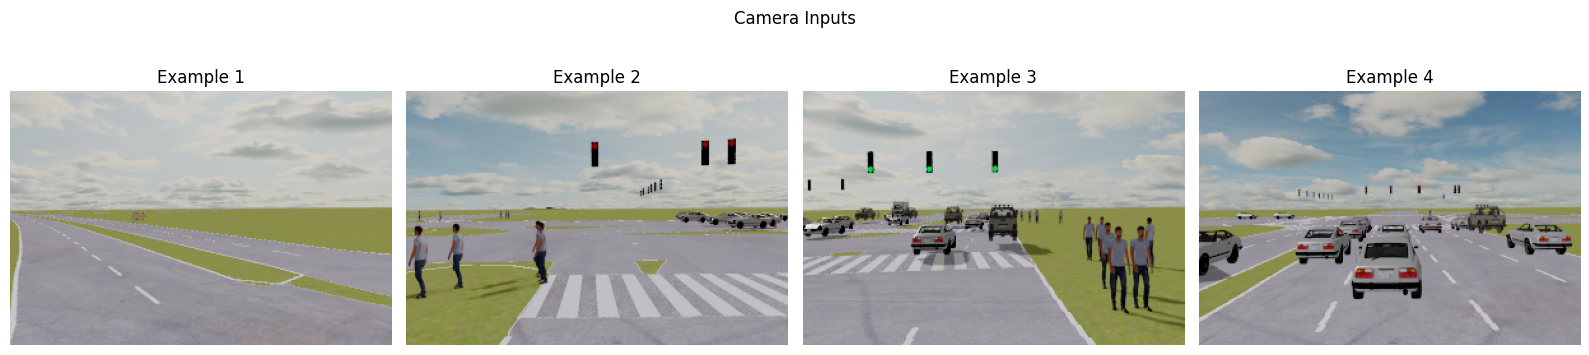

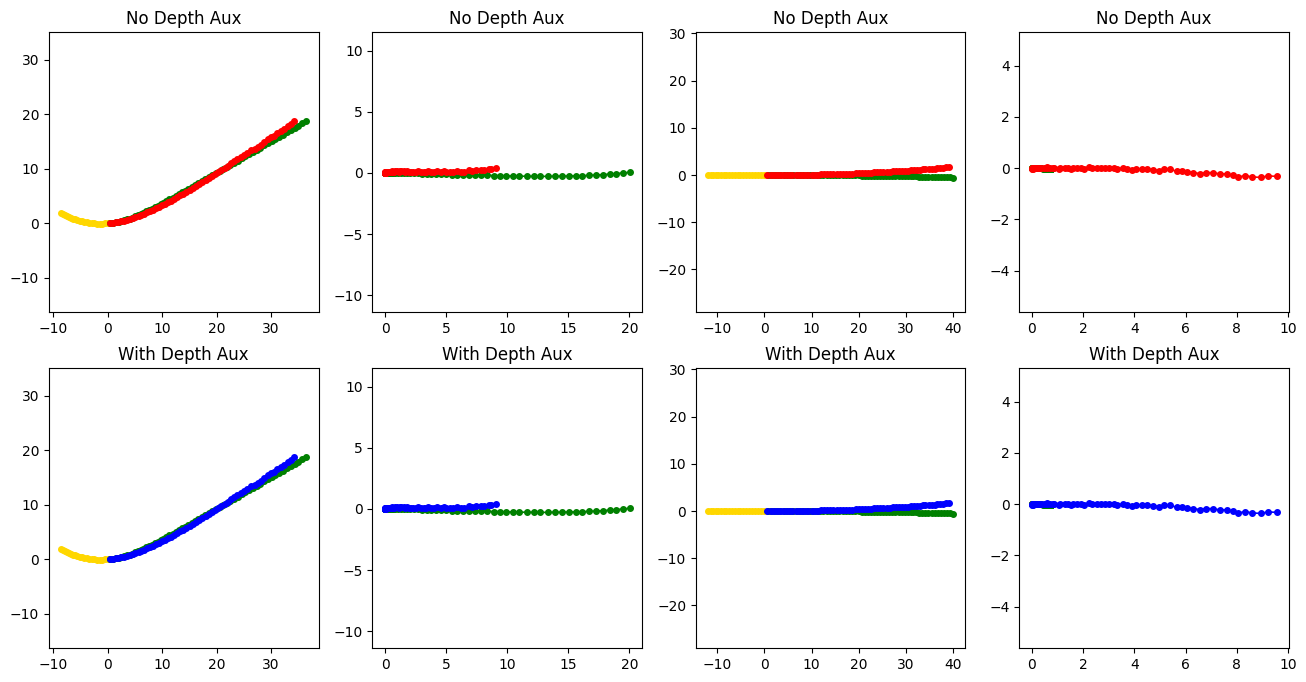

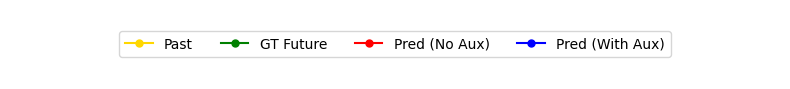

<Figure size 640x480 with 0 Axes>

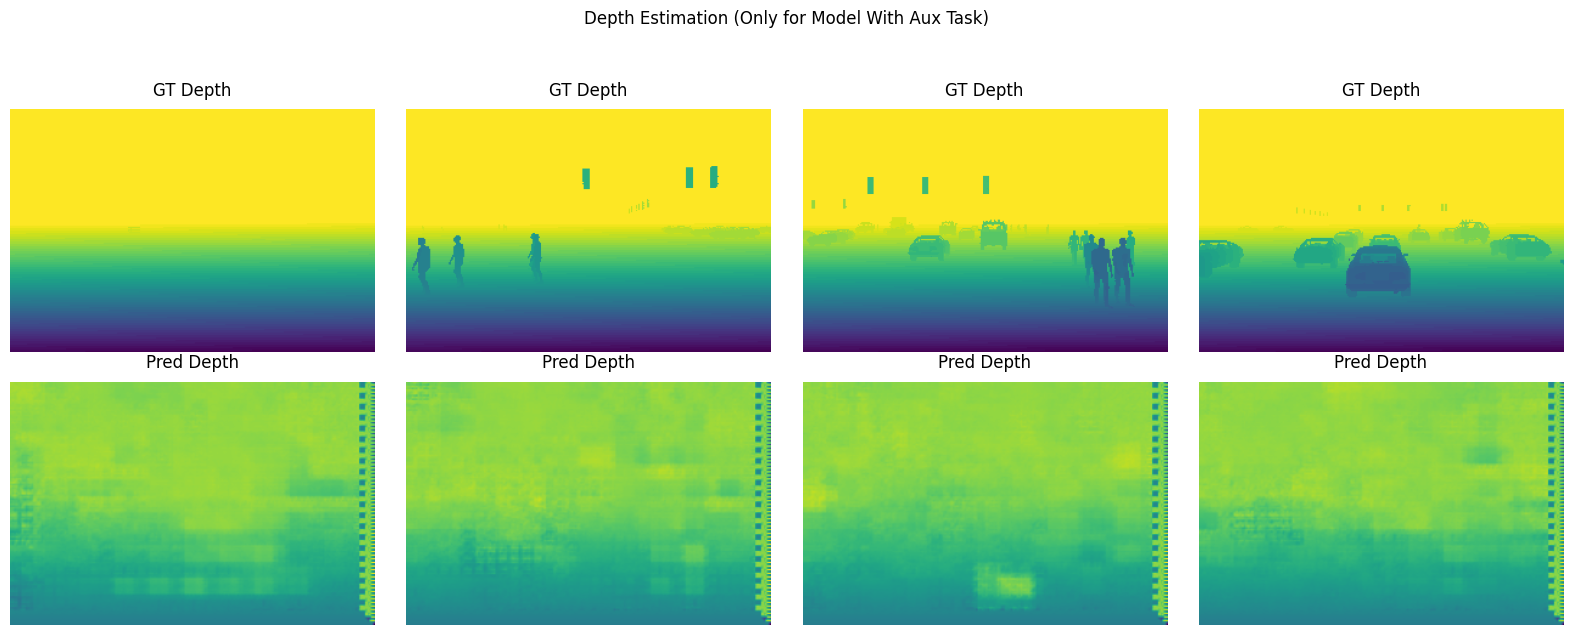

In [15]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    semantic = val_batch['semantic'].to(device)

    with torch.no_grad():
        #pred_no_aux, _ = model_no_aux(camera, history, depth)
        pred_no_aux, _ = model_with_aux(camera, history, depth, semantic)
        pred_with_aux, pred_depth = model_with_aux(camera, history, depth, semantic)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


visualize_comparison(val_loader, model_no_aux, model_with_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [16]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [17]:
import pandas as pd

model = model_with_aux

test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        depth = batch['depth'].to(device)
        semantic = batch['semantic'].to(device)

        pred_future, _ = model(camera, history, depth, semantic)

        all_plans.append(pred_future.cpu().numpy()[..., :2])

all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
